In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import math
from tensorflow.python.framework import ops
import xgboost as xgb
from sklearn.model_selection import train_test_split
%matplotlib inline
import sys

In [2]:
sys.path.append('C:/Users/45115/Anaconda3/mywhl/xgboost-master/python-package')
sys.path

['',
 'C:\\Python27\\Lib',
 'C:\\Python27\\DLLs',
 'C:\\Python27\\Lib\\lib-tk',
 'C:\\other-folders-on-the-path',
 'C:\\Users\\45115\\OneDrive\\Fking-ML\\Kaggle',
 'C:\\Users\\45115\\Anaconda3\\python36.zip',
 'C:\\Users\\45115\\Anaconda3\\DLLs',
 'C:\\Users\\45115\\Anaconda3\\lib',
 'C:\\Users\\45115\\Anaconda3',
 'C:\\Users\\45115\\Anaconda3\\lib\\site-packages',
 'C:\\Users\\45115\\Anaconda3\\lib\\site-packages\\xgboost-0.72-py3.6.egg',
 'C:\\Users\\45115\\Anaconda3\\lib\\site-packages\\win32',
 'C:\\Users\\45115\\Anaconda3\\lib\\site-packages\\win32\\lib',
 'C:\\Users\\45115\\Anaconda3\\lib\\site-packages\\Pythonwin',
 'C:\\Users\\45115\\Anaconda3\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\45115\\.ipython',
 'C:/Users/45115/Anaconda3/mywhl/xgboost-master/python-package']

In [4]:
train = pd.read_csv("datasets/digit/train.csv")
test = pd.read_csv('datasets/digit/test.csv')

In [4]:
X_train=train
X_test=test
Y_train=train["label"]

# XGB

In [5]:
import time
start_time = time.time()

In [6]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_train, Y_train, test_size=0.3, random_state=1)

## My xgboost

In [7]:
y = Xtrain.label
X = Xtrain.drop(['label'],axis=1)
val_y = Xtest.label
val_X = Xtest.drop(['label'],axis=1)

In [8]:
xgb_val = xgb.DMatrix(val_X, label = val_y)
xgb_train = xgb.DMatrix(X, label = y)
xgb_test = xgb.DMatrix(test)

In [12]:
params = {
    'booster':'gbtree',
'objective': 'multi:softmax', #多分类的问题
'num_class':10, # 类别数，与 multisoftmax 并用
'gamma':0.2,  # 用于控制是否后剪枝的参数,越大越保守，一般0.1、0.2这样子。
'max_depth':8, # 构建树的深度，越大越容易过拟合
'lambda':3,  # 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
'subsample':0.7, # 随机采样训练样本
'colsample_bytree':0.5, # 生成树时进行的列采样
'min_child_weight':3, 
# 这个参数默认是 1，是每个叶子里面 h 的和至少是多少，对正负样本不均衡时的 0-1 分类而言
#，假设 h 在 0.01 附近，min_child_weight 为 1 意味着叶子节点中最少需要包含 100 个样本。
#这个参数非常影响结果，控制叶子节点中二阶导的和的最小值，该参数值越小，越容易 overfitting。 
'silent':0 ,#设置成1则没有运行信息输出，最好是设置为0.
'eta': 0.01, # 如同学习率
'seed':1000,
#'nthread':7,# cpu 线程数
#'eval_metric': 'auc'
#'tree_method': 'gpu_hist'
}
plst = list(params.items())
num_rounds = 100
watchlist = [(xgb_train, 'train'), (xgb_val, 'val')]

model = xgb.train(plst, xgb_train, num_rounds, watchlist,early_stopping_rounds=100)

model.save_model('./model/xgb.model')
print("best best_ntree_limit", model.best_ntree_limit)
preds = model.predict(xgb_test, ntree_limit=model.best_ntree_limit)

np.savetxt('xgb_submission.csv', np.c_[range(1,len(train)+1),preds],delimiter=',',header='ImageId,Label',comments='',fmt='%d')

cost_time = time.time()-start_time
print("xgboost success!",'\n',"cost time:",cost_time,"(s)......")
cost_time = time.time() - start_time
print("xgboost successful!", '\n', "cost time:", cost_time, "(s)")

[0]	train-merror:0.115272	val-merror:0.145952
Multiple eval metrics have been passed: 'val-merror' will be used for early stopping.

Will train until val-merror hasn't improved in 100 rounds.
[1]	train-merror:0.084116	val-merror:0.111667
[2]	train-merror:0.072789	val-merror:0.097302
[3]	train-merror:0.069184	val-merror:0.09254
[4]	train-merror:0.06602	val-merror:0.089127
[5]	train-merror:0.064048	val-merror:0.087302
[6]	train-merror:0.061701	val-merror:0.085397
[7]	train-merror:0.05983	val-merror:0.080635
[8]	train-merror:0.058673	val-merror:0.079286
[9]	train-merror:0.057721	val-merror:0.07881
[10]	train-merror:0.057109	val-merror:0.077778
[11]	train-merror:0.057075	val-merror:0.078333
[12]	train-merror:0.055612	val-merror:0.076984
[13]	train-merror:0.053878	val-merror:0.074444
[14]	train-merror:0.053401	val-merror:0.074444
[15]	train-merror:0.052993	val-merror:0.073889
[16]	train-merror:0.051599	val-merror:0.073413
[17]	train-merror:0.051497	val-merror:0.073095
[18]	train-merror:0.05

ValueError: all the input array dimensions except for the concatenation axis must match exactly

ValueError: all the input array dimensions except for the concatenation axis must match exactly

## xgboost by others

In [ ]:
train_xy, val = train_test_split(train, test_size=0.3, random_state=1)

In [ ]:
print(val.head())

# tensorflow

In [28]:
X_train=train.iloc[:,1:]
X_test=test
Y_train=train["label"]

In [24]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.values.reshape(-1)].T
    return Y

In [29]:
X_train=X_train/255
X_test=X_test/255
X_train=X_train.values.reshape(42000,28,28,1)
X_test=X_test.values.reshape(28000,28,28,1)
print(X_train.shape)
print(X_test.shape)
Y_train=convert_to_one_hot(Y_train,10).T
print(Y_train.shape)

(42000, 28, 28, 1)
(28000, 28, 28, 1)
(42000, 10)


In [30]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [31]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    
    X = tf.placeholder(tf.float32,[None,n_H0,n_W0,n_C0],name="X")
    Y = tf.placeholder(tf.float32,[None,n_y],name="Y")

    
    return X, Y

In [32]:
def initialize_parameters():
    tf.set_random_seed(1)
    W1 = tf.get_variable("W1",[4,4,1,8],initializer=tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2",[2,2,8,16],initializer=tf.contrib.layers.xavier_initializer(seed = 0))
    

    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

In [33]:
def forward_propagation(X, parameters):
    
    W1 = parameters['W1']
    W2 = parameters['W2']
    Z1 = tf.nn.conv2d(X,W1,strides=[1,1,1,1],padding="SAME")
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1,ksize=[1,8,8,1],strides=[1,2,2,1],padding="SAME")
    Z2 = tf.nn.conv2d(P1,W2,strides=[1,1,1,1],padding="SAME")
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2,ksize=[1,4,4,1],strides=[1,4,4,1],padding="SAME")
    P2 = tf.contrib.layers.flatten(P2)
    Z3 = tf.contrib.layers.fully_connected(P2,10,activation_fn=None)
    return Z3

In [34]:
def compute_cost(Z3,Y):
    cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3,labels=Y))
    return cost

In [35]:
def model(X_train, Y_train,X_test, learning_rate = 0.005,
          num_epochs = 150, minibatch_size = 64, print_cost = True):
     
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []
    X, Y = create_placeholders(n_H0,n_W0,n_C0,n_y)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X,parameters)
    cost =compute_cost(Z3,Y)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
        sess.run(init)
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})
                minibatch_cost += temp_cost / num_minibatches
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        parameters = sess.run(parameters)
        correct_predictions = tf.equal(tf.argmax(Y, axis=1), tf.argmax(Z3, axis=1))
        accuracy = tf.reduce_mean(tf.cast(correct_predictions, 'float'))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        print("Train Accuracy:", train_accuracy)
        Y_test = sess.run(tf.argmax(Z3, 1), feed_dict={X: X_test})

        return Y_test

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Cost after epoch 0: 0.274599
Cost after epoch 5: 0.054583
Cost after epoch 10: 0.045383
Cost after epoch 15: 0.038064
Cost after epoch 20: 0.038345
Cost after epoch 25: 0.031340
Cost after epoch 30: 0.032700
Cost after epoch 35: 0.028143
Cost after epoch 40: 0.028125
Cost after epoch 45: 0.028891
Cost after epoch 50: 0.026335
Cost after epoch 55: 0.032141
Cost after epoch 60: 0.028745
Cost after epoch 65: 0.029087
Cost after epoch 70: 0.027192
Cost after epoch 75: 0.025379
Cost after epoch 80: 0.027370
Cost after epoch 85: 0.022779
Cost after epoch 90: 0.022848
Cost after epoch 95: 0.024560
Cost after epoch 100: 0.027715
Cost after epoch 105: 0.027827
Cost after epoch 110: 0.028055
Cost after epoch 115: 0.023226
Cost after epoch 120: 0.027839
Cost after epoch 125: 0.022293
Cost after epoch 130: 0.

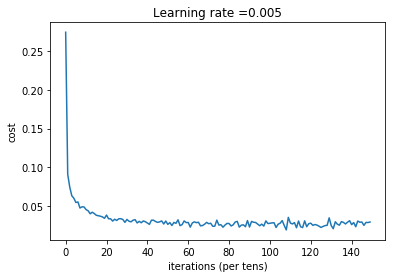

Tensor("Mean_1:0", shape=(), dtype=float32)


ResourceExhaustedError: OOM when allocating tensor with shape[42000,8,28,28] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: Conv2D = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](Conv2D-0-TransposeNHWCToNCHW-LayoutOptimizer, W1/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: Mean_1/_21 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_54_Mean_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'Conv2D', defined at:
  File "C:\Users\45115\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\45115\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\45115\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\45115\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\45115\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "C:\Users\45115\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\45115\Anaconda3\lib\asyncio\base_events.py", line 422, in run_forever
    self._run_once()
  File "C:\Users\45115\Anaconda3\lib\asyncio\base_events.py", line 1434, in _run_once
    handle._run()
  File "C:\Users\45115\Anaconda3\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\Users\45115\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 122, in _handle_events
    handler_func(fileobj, events)
  File "C:\Users\45115\Anaconda3\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\45115\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "C:\Users\45115\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\45115\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\45115\Anaconda3\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\45115\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\45115\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\45115\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\45115\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\45115\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\45115\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\45115\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\45115\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2901, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\45115\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-36-f748096b8a05>", line 1, in <module>
    Ytest=model(X_train,Y_train,X_test)
  File "<ipython-input-35-0a3b781a0849>", line 12, in model
    Z3 = forward_propagation(X,parameters)
  File "<ipython-input-33-44512d431e11>", line 5, in forward_propagation
    Z1 = tf.nn.conv2d(X,W1,strides=[1,1,1,1],padding="SAME")
  File "C:\Users\45115\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 1042, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "C:\Users\45115\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\45115\Anaconda3\lib\site-packages\tensorflow\python\util\deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "C:\Users\45115\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3155, in create_op
    op_def=op_def)
  File "C:\Users\45115\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1717, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[42000,8,28,28] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: Conv2D = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](Conv2D-0-TransposeNHWCToNCHW-LayoutOptimizer, W1/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: Mean_1/_21 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_54_Mean_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [36]:
Ytest=model(X_train,Y_train,X_test)

# handonebook

In [52]:
from sklearn.manifold import Isomap
iso = Isomap(n_components=2)
iso.fit(train)
data_projected = iso.transform(train)
data_projected.shape

MemoryError: 

In [49]:
Xtrain, Xtest = train_test_split(train, random_state=0)

In [50]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(Xtrain, Xtest)
y_model = model.predict(Xtest)

ValueError: bad input shape (10500, 785)

## Keras

In [6]:
import keras
import pandas as pd
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D

In [7]:
train = pd.read_csv("datasets/digit/train.csv")
test = pd.read_csv('datasets/digit/test.csv')

In [8]:
BATCH_SIZE = 128
NUM_CLASSES = 10
EPOCH = 12
img_rows, img_cols= 28, 28

In [9]:
train_x, train_y = train.values[:, 1:], train.values[:, 0]
test_x = test.values
train_y = keras.utils.np_utils.to_categorical(train_y, num_classes=NUM_CLASSES)
print(train_y)

[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [10]:
train_x_reshape = np.reshape(train_x, [-1, 28, 28, 1])
print(np.shape(train_x_reshape))
test_x_reshape = np.reshape(test_x, [-1, 28, 28, 1])
print(np.shape(test_x_reshape))

(42000, 28, 28, 1)
(28000, 28, 28, 1)


In [11]:
from keras import backend as K
print(K.image_data_format())

channels_last


In [12]:
train_x_nol = train_x_reshape.astype('float32') / 255
test_x_nol = test_x_reshape.astype('float32') / 255
input_shape = (img_rows, img_cols, 1)

In [13]:
model = keras.models.Sequential()

In [14]:
model.add(Conv2D(32,(3,3),
                activation='relu',
                input_shape=(28,28,1)))

In [15]:
model.add(Conv2D(64,(3,3),
                activation='relu',
                input_shape=(28,28,1)))

In [16]:
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

In [19]:
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES,activation='softmax'))
model.compile(loss=keras.metrics.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
model.fit(train_x, train_y, batch_size=BATCH_SIZE, epochs=EPOCH,
         verbose=1)

CLASSES = model.predict_classes(test_x, batch_size=BATCH_SIZE)

pd.DataFrame(
    {"ImageId": range(1, len(CLASSES) + 1), "Label": CLASSES}
).to_csv('output_keras.csv', index=False, header=True)
print('Done.')

ValueError: Input 0 is incompatible with layer flatten_3: expected min_ndim=3, found ndim=2